In [130]:
# Standard library imports
import math
import random

# Third-party library imports
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch
from matplotlib.ticker import MaxNLocator, FuncFormatter
from mpl_toolkits.mplot3d import Axes3D, art3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import nbimporter
import psycopg2
import pandas as pd
import nbimporter

# Local application/library specific imports
from Core import (get_cell, next_point, intermediate_points, encode_row, decode_row,
                  encode_morton_2d, decode_morton_2d, Ranges, decode_morton)
from matplotlib import patches

# Configurations
np.set_printoptions(suppress=True, precision=6)
random.seed(21)  # Setting the seed for the random library
np.random.seed(21)  # Setting the seed for numpy's RNG

In [131]:
def _count_generator(reader):
    b = reader(1024 * 1024)
    while b:
        yield b
        b = reader(1024 * 1024)


with open('test.csv', 'rb') as fp:
    c_generator = _count_generator(fp.raw.read)
    # count each \n
    count = sum(buffer.count(b'\n') for buffer in c_generator)
    print('Total lines:', count + 1)

Total lines: 6655065


In [132]:
def face_from_corners(corner1, corner2):
    # Create face from corners
    if corner1[0] == corner2[0]:  # Parallel to YZ plane
        face = [[corner1, [corner1[0], corner2[1], corner1[2]],
                 [corner1[0], corner2[1], corner2[2]], [corner1[0], corner1[1], corner2[2]]]]
    elif corner1[1] == corner2[1]:  # Parallel to XZ plane
        face = [[corner1, [corner2[0], corner1[1], corner1[2]],
                 [corner2[0], corner1[1], corner2[2]], [corner1[0], corner1[1], corner2[2]]]]
    elif corner1[2] == corner2[2]:  # Parallel to XY plane
        face = [[corner1, [corner2[0], corner1[1], corner1[2]],
                 [corner2[0], corner2[1], corner1[2]], [corner1[0], corner2[1], corner1[2]]]]
    else:
        print("Face is not axis-aligned. Unable to generate face.")
        return None

    return face

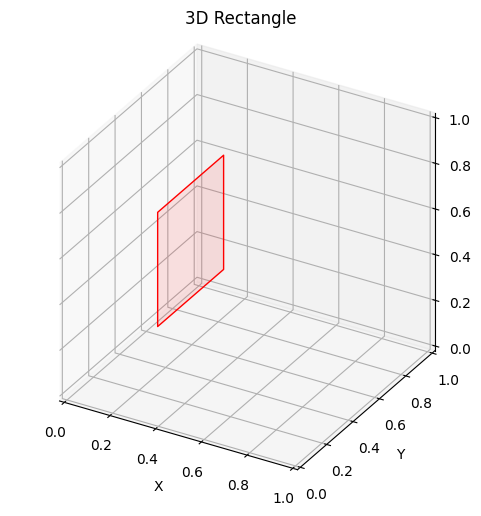

In [133]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
corner_1 = np.array([0.25, 0.25, 0.25])
corner_2 = np.array([0.25, 0.75, 0.75])
face = face_from_corners(corner_1, corner_2)
ax.add_collection3d(Poly3DCollection(face, facecolors='red', linewidths=1, edgecolors='r', alpha=0.1))
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('T')
ax.set_proj_type('ortho')
ax.set_box_aspect([1, 1, 1])
plt.title("3D Rectangle")
plt.show()

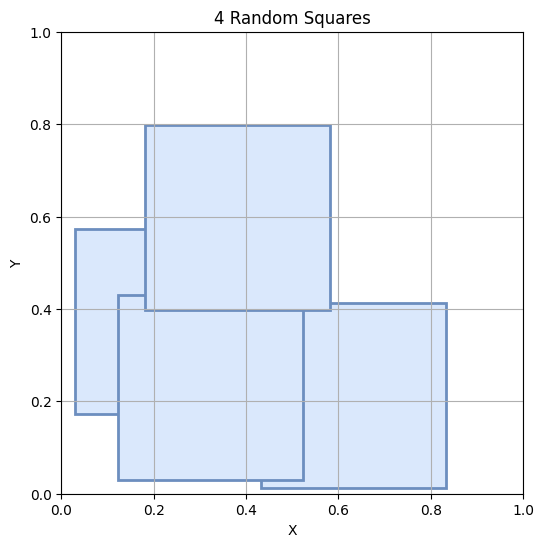

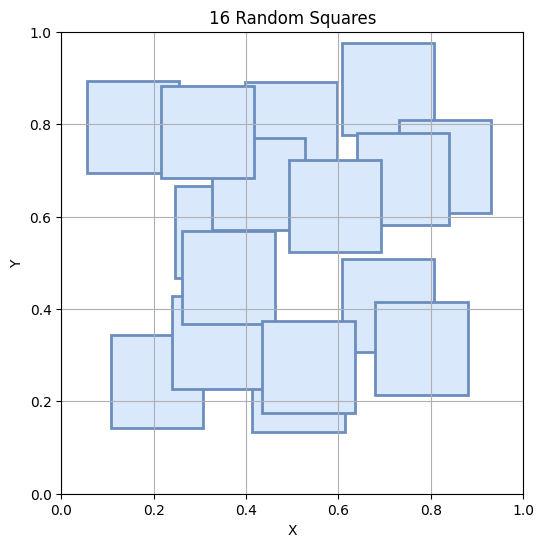

In [134]:
def square_from_corners(lower_left, width):
    # Generates a square given the lower left corner and the width.
    return plt.Rectangle(lower_left, width, width, facecolor='#DAE8FC', edgecolor='#6C8EBF', linewidth=2)


def draw_squares(num, width, title):
    # Draws a specified number of squares with a given width randomly distributed in a unit square.
    fig, ax = plt.subplots(figsize=(6, 6))
    for _ in range(num):
        min_val = width / 2
        max_val = 1 - width / 2
        center_x = np.random.uniform(min_val, max_val)
        center_y = np.random.uniform(min_val, max_val)
        lower_left_corner = (center_x - width / 2, center_y - width / 2)
        square = square_from_corners(lower_left_corner, width)
        ax.add_patch(square)
    plt.title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_aspect('equal', adjustable='box')
    plt.grid(True)
    plt.show()


# Drawing squares with the updated function
draw_squares(4, 0.4, "4 Random Squares")
draw_squares(16, 0.2, "16 Random Squares")

In [135]:
# Draw curve by a list of coordinates
def draw_curve(curve, title, col, avoid, depth, ax):
    # Helper function to format tick labels as binary and decimal
    def binary_decimal_formatter(x, pos, depth=depth):
        x = int(x)  # Convert to integer to remove decimal points in binary
        binary_format = f'{{:0{depth}b}}'.format(x)
        return f'{binary_format} ({x})'

    # Calculate and print the average distance between subsequent points
    def calculate_and_print_average_distance(curve, title):
        euclidean_distances = [math.sqrt((curve[i][0] - curve[i + 1][0]) ** 2 + (curve[i][1] - curve[i + 1][1]) ** 2)
                               for i in range(len(curve) - 1)]
        manhattan_distances = [abs(curve[i][0] - curve[i + 1][0]) + abs(curve[i][1] - curve[i + 1][1])
                               for i in range(len(curve) - 1)]

        average_euclidean = np.average(euclidean_distances)
        average_manhattan = np.average(manhattan_distances)

        print(f"Average Euclidean Distance Between Subsequent Points for {title} is {average_euclidean}")
        print(f"Average Manhattan Distance Between Subsequent Points for {title} is {average_manhattan}")

    # Plot configuration
    def configure_plot(ax, title, depth):
        ax.set_title(title)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_xlim(-0.25, 2 ** depth - 0.75)
        ax.set_ylim(-0.25, 2 ** depth - 0.75)
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: binary_decimal_formatter(x, pos, depth)))
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: binary_decimal_formatter(x, pos, depth)))
        ax.set_aspect('equal', adjustable='box')
        ax.grid(True)

    calculate_and_print_average_distance(curve, title)

    x_coords, y_coords = zip(*curve)

    # Decide on color mapping based on the 'col' parameter
    if col == "gra":
        colors = np.linspace(0, 1, len(curve))
        cmap = plt.get_cmap("viridis")

    # Draw the lines or curves between points
    for i in range(len(curve) - 1):
        start, end = np.array(curve[i]), np.array(curve[i + 1])
        distance = np.linalg.norm(end - start)
        color = cmap(colors[i]) if col == "gra" else col

        if distance != 1 and avoid:
            midpoint, offset, direction = (start + end) / 2, -0.25 / (distance - 1) * (distance - 1), np.array([end[1] - start[1], start[0] - end[0]])
            norm_dir = direction / np.linalg.norm(direction)
            midpoint += offset * norm_dir
            t = np.linspace(0, 1, num=50)
            curve_x, curve_y = (1 - t) ** 2 * start[0] + 2 * (1 - t) * t * midpoint[0] + t ** 2 * end[0], (1 - t) ** 2 * start[1] + 2 * (1 - t) * t * midpoint[1] + t ** 2 * end[1]
            ax.plot(curve_x, curve_y, color=color, linewidth=2.5)
        else:
            ax.plot([start[0], end[0]], [start[1], end[1]], color=color, marker='o', linewidth=2.5)

    # Plot points with specified color
    if col == "gra":
        for i, (x, y) in enumerate(curve):
            ax.plot(x, y, 'o', color=cmap(colors[i]), markersize=10)
    else:
        ax.plot(x_coords, y_coords, 'o', color=color, markersize=10)

    # Annotate each point with its order
    for i, (x, y) in enumerate(curve):
        ax.text(x, y, f' {i}', color='black', fontsize=10)

    configure_plot(ax, title, depth)

In [136]:
# Generate code
code_depth_1 = list(range(4 ** 1))
code_depth_2 = list(range(4 ** 2))
code_depth_3 = list(range(4 ** 3))
code_depth_4 = list(range(4 ** 4))

Average Euclidean Distance Between Subsequent Points for Row-1 is 1.1380711874576983
Average Manhattan Distance Between Subsequent Points for Row-1 is 1.3333333333333333
Average Euclidean Distance Between Subsequent Points for Row-2 is 1.4324555320336758
Average Manhattan Distance Between Subsequent Points for Row-2 is 1.6
Average Euclidean Distance Between Subsequent Points for Row-3 is 1.674563090207275
Average Manhattan Distance Between Subsequent Points for Row-3 is 1.7777777777777777


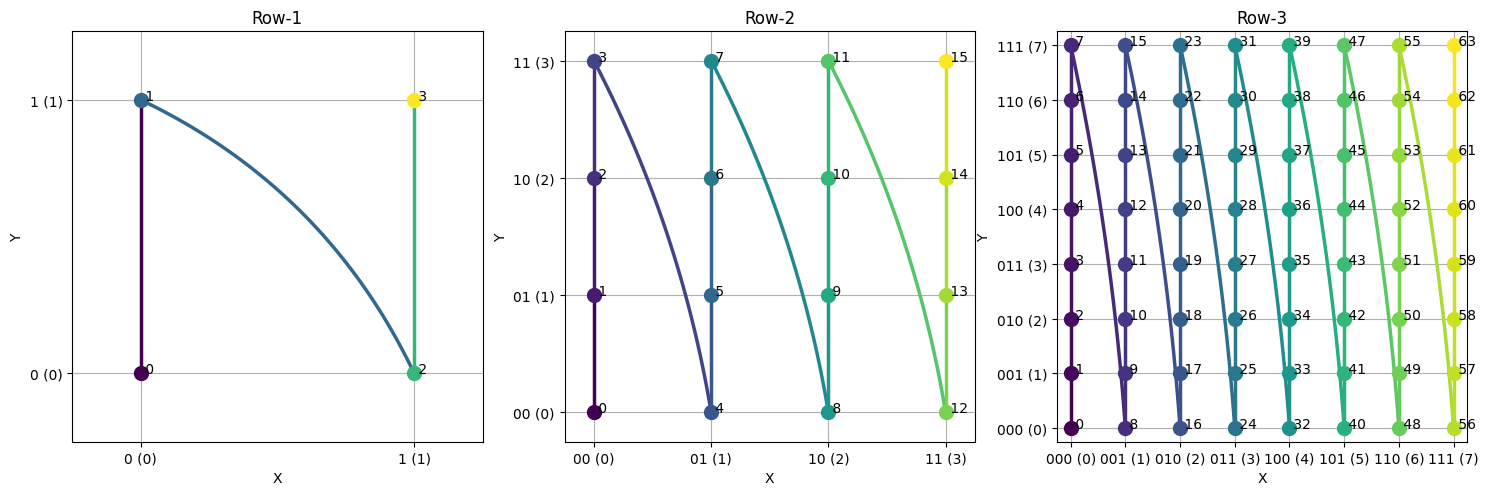

In [137]:
# Map to row curve
curve_row_depth_1 = [decode_row(code, 1) for code in code_depth_1]
curve_row_depth_2 = [decode_row(code, 2) for code in code_depth_2]
curve_row_depth_3 = [decode_row(code, 3) for code in code_depth_3]
# Draw row curve
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
draw_curve(curve_row_depth_1, "Row-1", "gra", True, 1, axs[0])
draw_curve(curve_row_depth_2, "Row-2", "gra", True, 2, axs[1])
draw_curve(curve_row_depth_3, "Row-3", "gra", True, 3, axs[2])
fig.savefig("figs/row_curve.pdf", bbox_inches='tight')
plt.show()

Average Euclidean Distance Between Subsequent Points for Morton-1 is 1.1380711874576983
Average Manhattan Distance Between Subsequent Points for Morton-1 is 1.3333333333333333
Average Euclidean Distance Between Subsequent Points for Morton-2 is 1.3098372689604636
Average Manhattan Distance Between Subsequent Points for Morton-2 is 1.6
Average Euclidean Distance Between Subsequent Points for Morton-3 is 1.460093004283016
Average Manhattan Distance Between Subsequent Points for Morton-3 is 1.7777777777777777


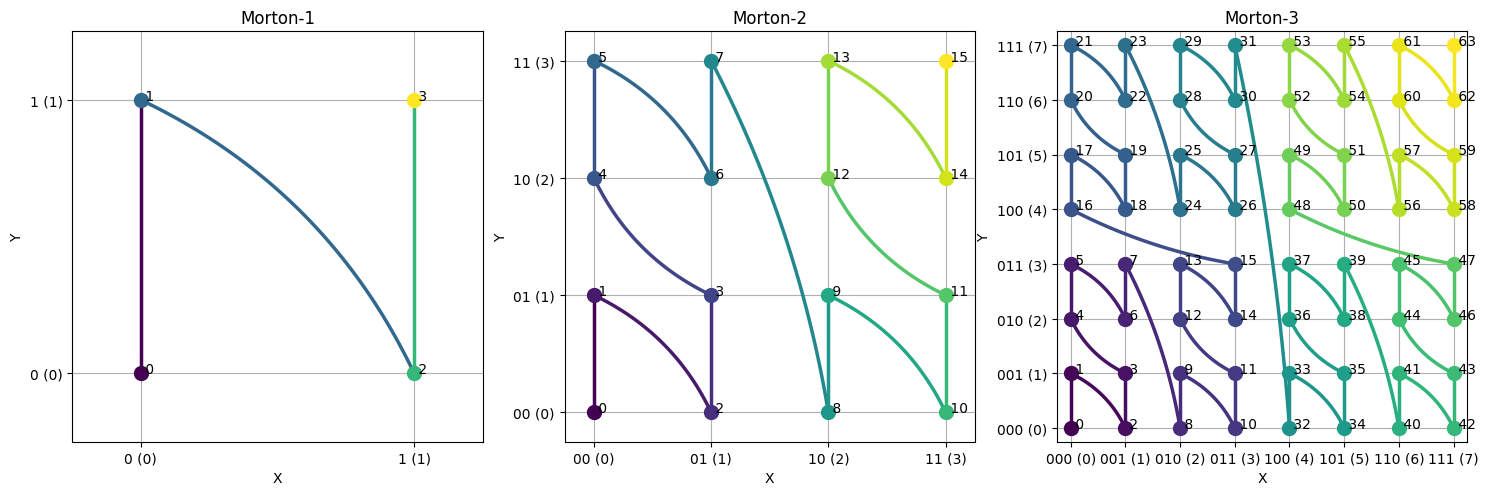

In [138]:
# Map to morton curve
curve_morton_depth_1 = [decode_morton_2d(code, 1) for code in code_depth_1]
curve_morton_depth_2 = [decode_morton_2d(code, 2) for code in code_depth_2]
curve_morton_depth_3 = [decode_morton_2d(code, 3) for code in code_depth_3]
# Draw morton curve
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
draw_curve(curve_morton_depth_1, "Morton-1", "gra", True, 1, axs[0])
draw_curve(curve_morton_depth_2, "Morton-2", "gra", True, 2, axs[1])
draw_curve(curve_morton_depth_3, "Morton-3", "gra", True, 3, axs[2])
fig.savefig("figs/morton_curve.pdf", bbox_inches='tight')
plt.show()

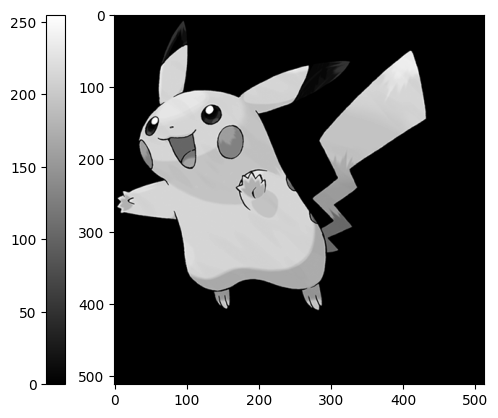

In [139]:
# Open original image
image = Image.open('pika.png')
image = image.convert('L')
image = np.array(image)

plt.imshow(image, cmap='gray')
plt.colorbar(location='left')
plt.savefig('figs/gray_pika.pdf', bbox_inches='tight')
plt.show()

In [140]:
# Use row curve to distribute
series = []

for i in range(512 * 512):
    x, y = decode_row(i, 9)
    series.append(image[x][y])

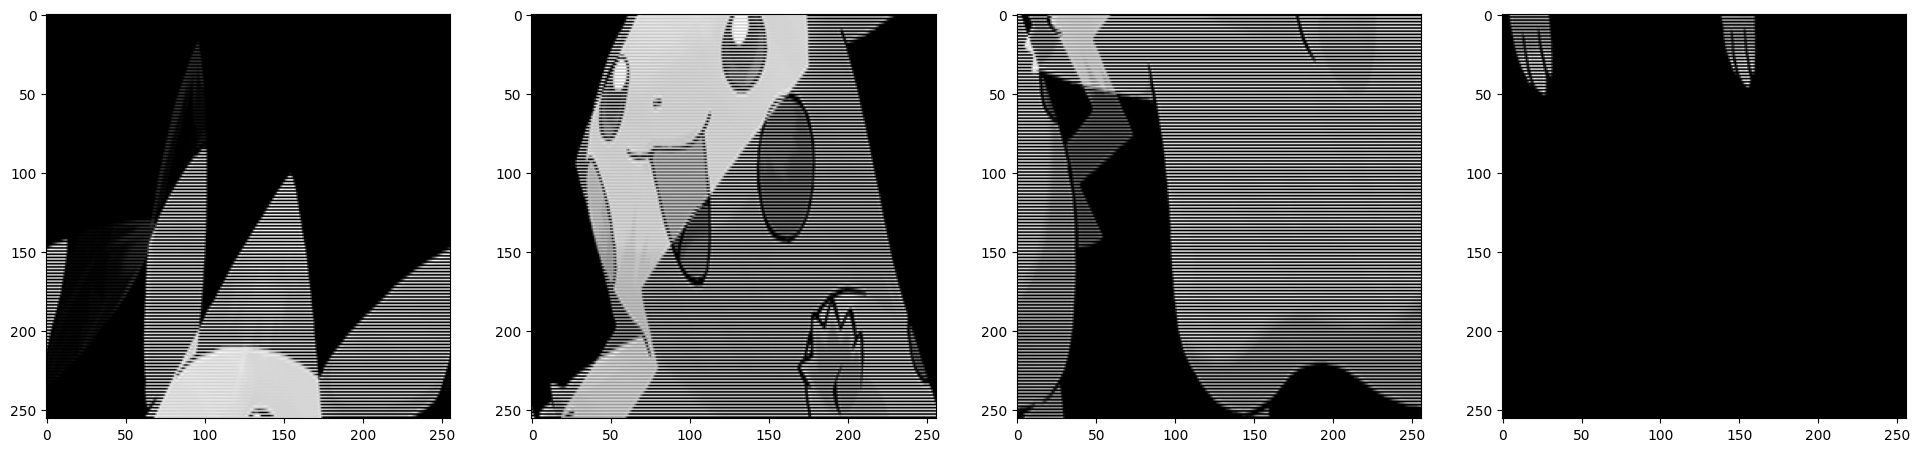

In [141]:
# Split by continuous row block
fig, axs = plt.subplots(1, 4, figsize=(24, 6))
for i in range(4):
    sub_series = series[i * 256 ** 2: (i + 1) * 256 ** 2]
    block = np.zeros((256, 256))
    for j, val in enumerate(sub_series):
        x, y = decode_row(j, 8)
        block[x][y] = val
    axs[i].imshow(block, cmap='gray')
fig.savefig("figs/row_block.pdf", bbox_inches='tight')
plt.show()

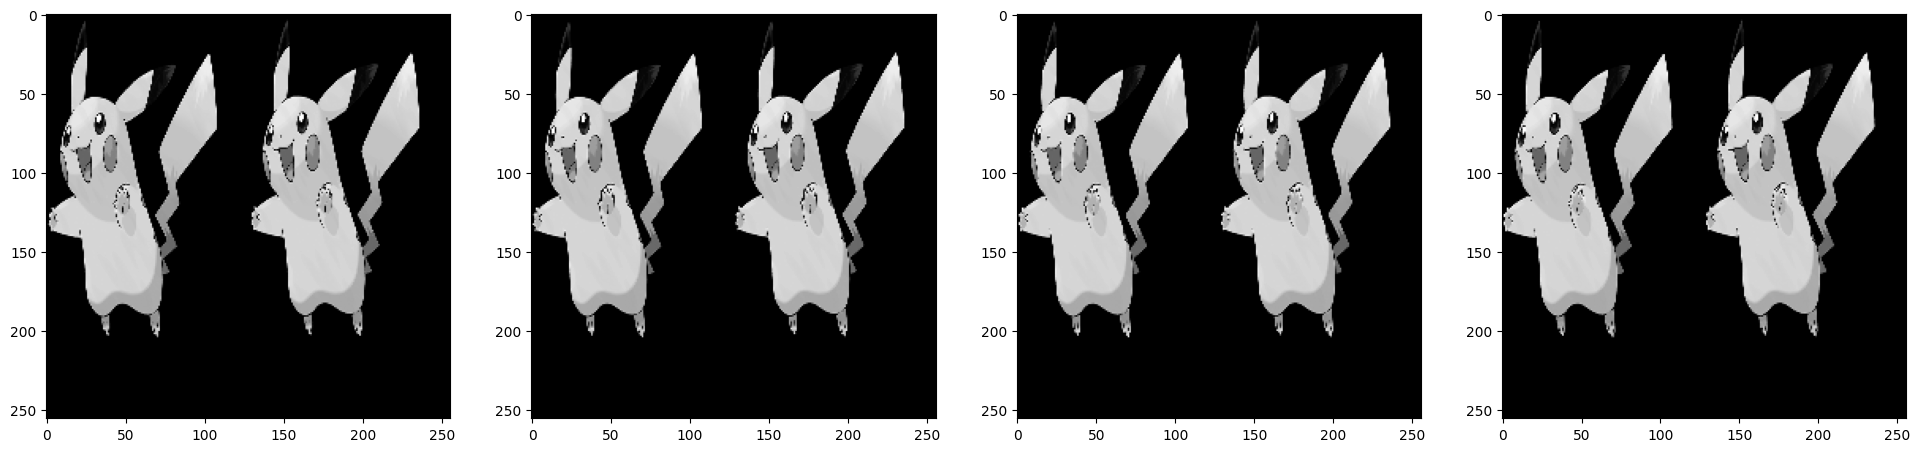

In [142]:
# Split by jumping row sample
fig, axs = plt.subplots(1, 4, figsize=(24, 6))
for i in range(4):
    sub_series = series[i::4]
    sample = np.zeros((256, 256))
    for j, val in enumerate(sub_series):
        x, y = decode_row(j, 8)
        sample[x][y] = val
    axs[i].imshow(sample, cmap='gray')
fig.savefig("figs/row_sample.pdf", bbox_inches='tight')
plt.show()

In [143]:
# Use morton curve to distribute
series = []

for i in range(512 * 512):
    x, y = decode_morton_2d(i, 9)
    series.append(image[x][y])

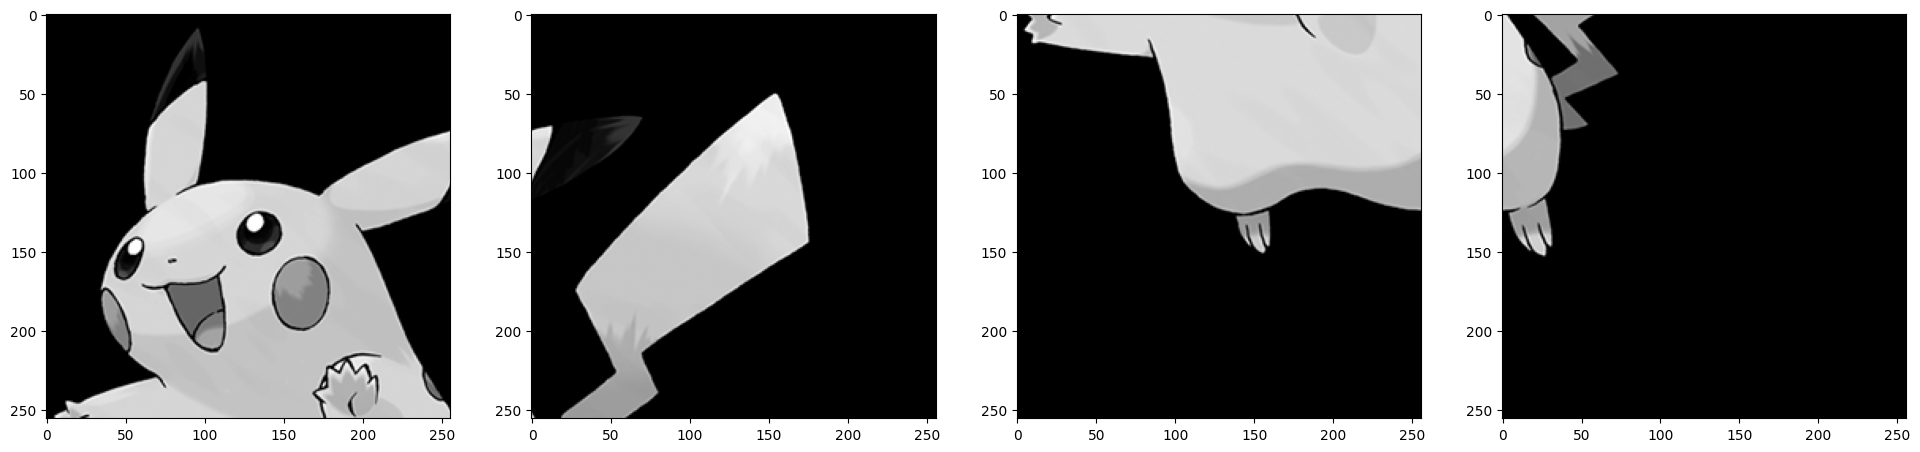

In [144]:
# Split by continuous morton block
fig, axs = plt.subplots(1, 4, figsize=(24, 6))
for i in range(4):
    sub_series = series[i * 256 ** 2: (i + 1) * 256 ** 2]
    block = np.zeros((256, 256))
    for j, val in enumerate(sub_series):
        x, y = decode_morton_2d(j, 8)
        block[x][y] = val
    axs[i].imshow(block, cmap='gray')
fig.savefig("figs/morton_block.pdf", bbox_inches='tight')
plt.show()

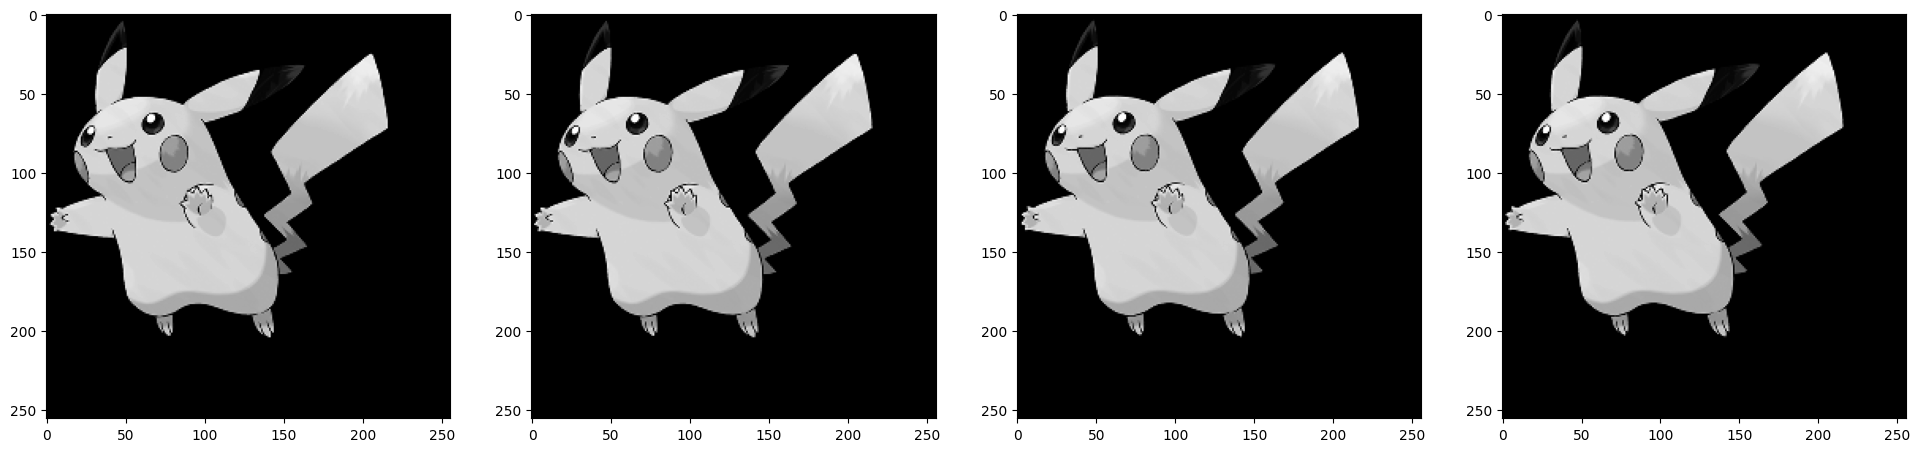

In [145]:
# Split by jumping morton sample
fig, axs = plt.subplots(1, 4, figsize=(24, 6))
for i in range(4):
    sub_series = series[i::4]
    sample = np.zeros((256, 256))
    for j, val in enumerate(sub_series):
        x, y = decode_morton_2d(j, 8)
        sample[x][y] = val
    axs[i].imshow(sample, cmap='gray')
fig.savefig("figs/morton_sample.pdf", bbox_inches='tight')
plt.show()

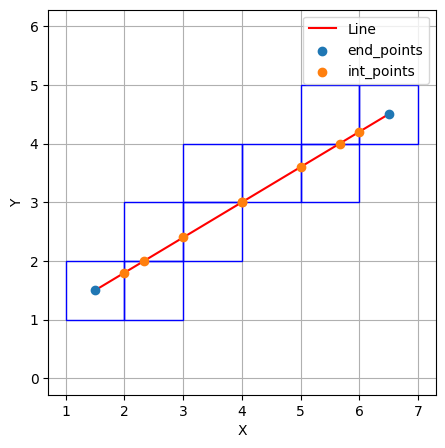

In [146]:
p0_2d = np.array([1.5, 1.5])
p1_2d = np.array([6.5, 4.5])
end_points = np.array([p0_2d, p1_2d])
int_points = intermediate_points(p0_2d, p1_2d)
all_points = np.concatenate((end_points, int_points))
all_cells = [get_cell(point) for point in all_points]
all_cells = list(set(all_cells))

fig = plt.figure(figsize=(5, 5))

plt.plot([p0_2d[0], p1_2d[0]], [p0_2d[1], p1_2d[1]], 'r', label='Line', zorder=3)
plt.scatter(end_points[:, 0], end_points[:, 1], label='end_points', zorder=4)
plt.scatter(int_points[:, 0], int_points[:, 1], label='int_points', zorder=4)

for cell in all_cells:
    bottom_left_corner = cell
    plt.gca().add_patch(patches.Rectangle(bottom_left_corner, 1, 1, fill=False, edgecolor='blue', linewidth=1, zorder=2))

plt.xlabel('X')
plt.ylabel('Y')
plt.xticks(np.arange(0, 8, 1))
plt.yticks(np.arange(0, 8, 1))
plt.axis('equal')
plt.grid(True, zorder=1)
plt.legend()
plt.show()
fig.savefig("figs/splitting_2d.pdf", bbox_inches='tight')

In [147]:
def get_cube(cell):
    corners = np.array([
        [cell[0] + 0, cell[1] + 0, cell[2] + 0],
        [cell[0] + 1, cell[1] + 0, cell[2] + 0],
        [cell[0] + 1, cell[1] + 1, cell[2] + 0],
        [cell[0] + 0, cell[1] + 1, cell[2] + 0],
        [cell[0] + 0, cell[1] + 0, cell[2] + 1],
        [cell[0] + 1, cell[1] + 0, cell[2] + 1],
        [cell[0] + 1, cell[1] + 1, cell[2] + 1],
        [cell[0] + 0, cell[1] + 1, cell[2] + 1],
    ])

    sides = [
        [corners[0], corners[1], corners[2], corners[3]],  # Bottom
        [corners[4], corners[5], corners[6], corners[7]],  # Top
        [corners[0], corners[1], corners[5], corners[4]],  # Side
        [corners[1], corners[2], corners[6], corners[5]],  # Side
        [corners[2], corners[3], corners[7], corners[6]],  # Side
        [corners[3], corners[0], corners[4], corners[7]],  # Side
    ]

    faces = []

    for side in sides:
        x = [point[0] for point in side]
        y = [point[1] for point in side]
        z = [point[2] for point in side]
        x.append(side[0][0])  # Closing the loop
        y.append(side[0][1])  # Closing the loop
        z.append(side[0][2])  # Closing the loop
        face = [x, y, z]
        faces.append(face)
    return faces

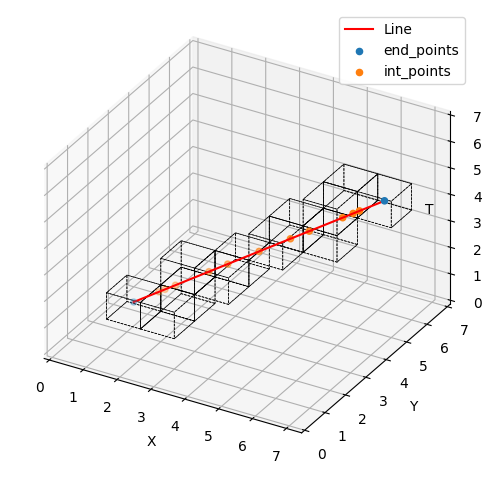

In [148]:
p0_3d = np.array([1.5, 1.5, 1.5])
p1_3d = np.array([6.5, 5.5, 4.5])
end_points = np.array([p0_3d, p1_3d])
int_points = intermediate_points(p0_3d, p1_3d)
all_points = np.concatenate((end_points, int_points))

all_cells = [get_cell(point) for point in all_points]
all_cells = list(set(all_cells))

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot([p0_3d[0], p1_3d[0]], [p0_3d[1], p1_3d[1]], [p0_3d[2], p1_3d[2]], 'r', label='Line', zorder=3)
ax.scatter(end_points[:, 0], end_points[:, 1], end_points[:, 2], label='end_points', zorder=4)
ax.scatter(int_points[:, 0], int_points[:, 1], int_points[:, 2], label='int_points', zorder=4)

for cell in all_cells:
    faces = get_cube(cell)
    for face in faces:
        ax.plot(face[0], face[1], face[2], 'k--', linewidth=0.5, zorder=2)  # Draw side

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('T', labelpad=-30)
ax.set_xticks(np.arange(0, 8, 1))
ax.set_yticks(np.arange(0, 8, 1))
ax.set_zticks(np.arange(0, 8, 1))
ax.set_proj_type('ortho')
ax.set_box_aspect([1, 1, 0.75])
ax.grid(True, zorder=1)
plt.legend()
plt.show()
fig.savefig("figs/splitting_3d.pdf", bbox_inches='tight')

In [149]:
class Expression:
    def __init__(self, dimension, relation=None, value=None):
        if isinstance(dimension, str):
            string = dimension.split()
            self.dimension = int(string[0].split("_")[1])
            self.relation = str(string[1])
            self.value = float(string[2])
        else:
            self.dimension = dimension
            self.relation = relation
            self.value = value

    def __str__(self):
        return "x_{} {} {}".format(self.dimension, self.relation, self.value)

    def __repr__(self):
        return str(self)

In [150]:
class HalfSpace:
    def __init__(self, n, d):
        self.n = n
        self.d = d

    def __str__(self):
        return "normal: {}, displace: {}".format(self.n, self.d)

    def __repr__(self):
        return str(self)

In [151]:
class QueryShape:
    def __init__(self, spaces):
        self.spaces = spaces

    def __str__(self):
        return "spaces: {}".format(self.spaces)

    def __repr__(self):
        return str(self)

In [152]:
def point_halfspace_relation(point, space):
    # Calculate dot product
    dot_product = np.dot(space.n, point)
    # Determine relation
    if dot_product > space.d:
        return -1  # external
    elif dot_product < space.d:
        return 1  # internal
    else:
        return 0  # on

In [153]:
def point_halfspace_distance(point, space):
    distance = abs(np.dot(space.n, point) - space.d) / np.linalg.norm(space.n)
    return distance

In [154]:
def point_queryShape_relation(point, shape):
    relations = []
    for space in shape.spaces:
        relations.append(point_halfspace_relation(point, space))
    if 0 in relations:
        return 0  # on
    elif -1 in relations:
        return -1  # external
    else:
        return 1  # internal

In [155]:
def halfspace_from_expression(number_dimension, expression):
    # Parse the expression
    dimension = expression.dimension
    relation = expression.relation
    value = expression.value
    # Initialize a normal vector of zeros with size equal to the number of dimensions
    n = np.zeros(number_dimension)
    # Determine the normal vector and displacement based on the relation,
    # if relation is '<=' relation, the normal points 'outwards'
    if relation == '<=':
        n[dimension - 1] = 1
        d = value
    else:
        n[dimension - 1] = -1
        d = -value
    # No need to normalize here as these are already unit vectors by construction
    return HalfSpace(n, d)

In [156]:
def halfSpace_from_geometry(geometry):
    A, B = geometry
    A = np.array(A)
    B = np.array(B)
    # Calculate direction vector and normal vector
    direction = B - A
    n = np.array([-direction[1], direction[0]])
    n = n / np.linalg.norm(n)  # Normalize the normal vector
    # Calculate displacement as the projection of A onto the normal vector
    d = np.dot(n, A)
    return HalfSpace(n, d)

In [157]:
expression_1 = Expression("x_1 >= 2.5")  # expression_1 = Expression(1, ">=", 3.5)
expression_2 = Expression("x_1 <= 7.5")
expression_3 = Expression("x_2 >= 2.5")
expression_4 = Expression("x_2 <= 7.5")
expressions = [expression_1, expression_2, expression_3, expression_4]
halfspaces = [halfspace_from_expression(2, expression) for expression in expressions]
queryShape = QueryShape(halfspaces)
test_1 = point_queryShape_relation(np.array([2.0, 2.0]), queryShape)
test_2 = point_queryShape_relation(np.array([8.0, 8.0]), queryShape)
test_3 = point_queryShape_relation(np.array([2.5, 8.0]), queryShape)
test_4 = point_queryShape_relation(np.array([2.5, 2.5]), queryShape)
print(queryShape)
print(test_1, test_2, test_3, test_4)

spaces: [normal: [-1.  0.], displace: -2.5, normal: [1. 0.], displace: 7.5, normal: [ 0. -1.], displace: -2.5, normal: [0. 1.], displace: 7.5]
-1 -1 0 0


In [158]:
geometry_1 = [np.array([1.5, 1.5]), np.array([3.5, 6.0])]
geometry_2 = [np.array([3.5, 6.0]), np.array([8.0, 8.0])]
geometry_3 = [np.array([8.0, 8.0]), np.array([6.0, 3.5])]
geometry_4 = [np.array([6.0, 3.5]), np.array([1.5, 1.5])]
geometries = [geometry_1, geometry_2, geometry_3, geometry_4]
halfspaces = [halfSpace_from_geometry(geometry) for geometry in geometries]
queryShape = QueryShape(halfspaces)
queryShape = QueryShape(halfspaces)
test_1 = point_queryShape_relation(np.array([2.0, 2.0]), queryShape)
test_2 = point_queryShape_relation(np.array([8.0, 8.0]), queryShape)
test_3 = point_queryShape_relation(np.array([1.5, 1.5]), queryShape)
test_4 = point_queryShape_relation(np.array([3.5, 6.0]), queryShape)
print(queryShape)
print(test_1, test_2, test_3, test_4)

spaces: [normal: [-0.913812  0.406138], displace: -0.7615096238502145, normal: [-0.406138  0.913812], displace: 4.061384660534477, normal: [ 0.913812 -0.406138], displace: 4.061384660534477, normal: [ 0.406138 -0.913812], displace: -0.7615096238502144]
1 0 0 0


In [159]:
depth_tree = 3
depth_query = 3
threshold_size = 1

random_integers = [random.randint(0, 10) for _ in range(8 * 8)]
df = pd.DataFrame(random_integers, columns=['size'])
df.reset_index(inplace=True)
df.rename(columns={'index': 'morton'}, inplace=True)

dfs = []
for i in range(depth_tree + 1):
    dfs.append(df)
    df = df.copy()
    df["morton"] = df.apply(lambda x: int(x["morton"] / 4), axis=1)
    df = df.groupby('morton')['size'].sum()
    df = df.reset_index()
    df.columns = ['morton', 'size']
dfs.reverse()
dist = []
for i, df in enumerate(dfs):
    dist.append(df.values.tolist())

In [160]:
class nDNode:
    def __init__(self, depth_tree, depth_node, morton, size):
        self.depth_tree = depth_tree
        self.depth_node = depth_node
        self.morton = morton
        self.left = morton * 4 ** (depth_tree - depth_node)
        self.right = (morton + 1) * 4 ** (depth_tree - depth_node) - 1
        self.size = size
        corner_min = decode_morton_2d(self.left, depth_tree + 1)
        corner_max = decode_morton_2d(self.right, depth_tree + 1)
        corner_max = tuple(component + 1 for component in corner_max)
        self.box = {"min": corner_min, "max": corner_max}
        self.child = list()

    def __str__(self):
        return "depth_tree:{},\t depth_node:{},\t morton:{},\t left:{},\t right:{},\t size:{}".format(self.depth_tree, self.depth_node, self.morton, self.left, self.right, self.size)

In [161]:
def check_relation(relations):
    case_in = 1 in relations
    case_on = 0 in relations
    case_ex = -1 in relations

    if case_ex:
        if case_in:
            return "intersected"  # Both 1 and -1 are present
        else:
            return "outside"  # Only -1 is present
    elif case_in or case_on:
        return "inside"  # Either 1 or 0 is present without -1
    else:
        return None  # None of 1, 0, -1 are present

In [162]:
def tree_shape_relation(treeBox, queryShape):
    # Generate all corners of treeBox and shapeBox
    tree_corners = [
        [x, y]
        for x in [treeBox['min'][0], treeBox['max'][0]]
        for y in [treeBox['min'][1], treeBox['max'][1]]
    ]

    tree_to_shape = [point_queryShape_relation(corner, queryShape) for corner in tree_corners]

    if check_relation(tree_to_shape) == "inside":
        return "inside"
    elif check_relation(tree_to_shape) == "intersected":
        return "intersected"
    else:
        return "outside"

In [163]:
class nDTree:
    def __init__(self, depth_tree, dist, threshold_size):
        # Initialize the root node
        self.root = nDNode(depth_tree, 0, dist[0][0][0], dist[0][0][1])
        # Consider root node as parent
        parents = [self.root]
        # For each level of the tree
        for i in range(1, depth_tree + 1):
            # Map the parents and their children
            children = dist[i]
            j = 0
            new_parents = []
            # For each parent
            for parent in parents:
                # Size of parent is so small, no need to refine
                if parent.size <= threshold_size:
                    continue
                # Not all the children are traversed
                while j < len(children):
                    # If this child belong to this parent
                    if parent.left <= children[j][0] * 4 ** (depth_tree - i) <= parent.right:
                        # If the parent does not have child currently
                        if parent.child is None:
                            parent.child = []
                        else:
                            pass
                        # Map the parent and the child
                        parent.child.append(nDNode(depth_tree, i, children[j][0], children[j][1]))
                        j = j + 1
                    else:
                        break
            # For the next depth
            for parent in parents:
                if parent.child is not None:
                    new_parents.extend(parent.child)
            parents = new_parents

    def shapeQuery(self, queryShape, depth_query, tree_shape_relation):
        ranges = []
        parents = list(reversed([child for child in self.root.child]))

        while parents:
            parent = parents.pop()
            cant_be_refined = parent.depth_node == depth_query
            can_be_refined = parent.depth_node < depth_query and parent.child
            if tree_shape_relation(parent.box, queryShape) == "intersected":
                if cant_be_refined:
                    ranges.append((parent.left, parent.right, 0, parent.size))
                    print("intersected, can't be refined", parent, parent.box)
                elif can_be_refined:
                    parents.extend(reversed(parent.child))
                    print("intersected, can be refined", parent, parent.box)
            elif tree_shape_relation(parent.box, queryShape) == "inside":
                ranges.append((parent.left, parent.right, 1, parent.size))
                print("inside", parent, parent.box)
            else:
                ranges.append((parent.left, parent.right, -1, parent.size))
                print("outside", parent, parent.box)
        return ranges

In [164]:
tree = nDTree(depth_tree, dist, threshold_size)
ranges = tree.shapeQuery(queryShape, depth_query, tree_shape_relation)

intersected, can be refined depth_tree:3,	 depth_node:1,	 morton:0,	 left:0,	 right:15,	 size:79 {'min': (0, 0), 'max': (4, 4)}
intersected, can be refined depth_tree:3,	 depth_node:2,	 morton:0,	 left:0,	 right:3,	 size:24 {'min': (0, 0), 'max': (2, 2)}
outside depth_tree:3,	 depth_node:3,	 morton:0,	 left:0,	 right:0,	 size:2 {'min': (0, 0), 'max': (1, 1)}
outside depth_tree:3,	 depth_node:3,	 morton:1,	 left:1,	 right:1,	 size:6 {'min': (0, 1), 'max': (1, 2)}
outside depth_tree:3,	 depth_node:3,	 morton:2,	 left:2,	 right:2,	 size:6 {'min': (1, 0), 'max': (2, 1)}
intersected, can't be refined depth_tree:3,	 depth_node:3,	 morton:3,	 left:3,	 right:3,	 size:10 {'min': (1, 1), 'max': (2, 2)}
intersected, can be refined depth_tree:3,	 depth_node:2,	 morton:1,	 left:4,	 right:7,	 size:21 {'min': (0, 2), 'max': (2, 4)}
outside depth_tree:3,	 depth_node:3,	 morton:4,	 left:4,	 right:4,	 size:4 {'min': (0, 2), 'max': (1, 3)}
outside depth_tree:3,	 depth_node:3,	 morton:5,	 left:5,	 right:5

In [165]:
boxes = []
for item in ranges:
    min_corner = decode_morton_2d(item[0], depth_tree)
    max_corner = decode_morton_2d(item[1], depth_tree)
    max_corner = tuple([x + 1 for x in max_corner])
    box = {"min_corner": min_corner, "max_corner": max_corner, "color": item[2], "alpha": item[3]}
    boxes.append(box)

In [166]:
alphas = []
for box in boxes:
    alphas.append(box["alpha"])

alphaMax = max(alphas)

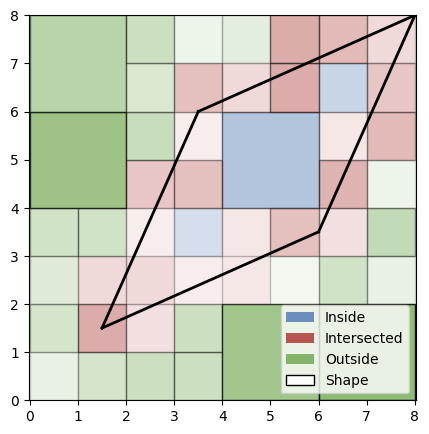

In [167]:
fig, ax = plt.subplots(figsize=(5, 5))

# Map for color codes
color_map = {-1: '#82B366', 0: '#B85450', 1: '#6C8EBF'}

for line in geometries:
    start_point, end_point = line
    ax.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], 'k-', lw=2)  # 'k-' for black line

for box in boxes:
    min_corner = box['min_corner']
    max_corner = box['max_corner']
    color_code = box['color']
    alpha = 0.1 + (box['alpha'] / alphaMax) * 4 / 5

    width = max_corner[0] - min_corner[0]
    height = max_corner[1] - min_corner[1]
    color = color_map[color_code]

    rect = Rectangle(min_corner, width, height, linewidth=1, edgecolor='black', facecolor=color, alpha=alpha)
    ax.add_patch(rect)

legend_elements = [
    Patch(facecolor=color_map[1], label='Inside'),
    Patch(facecolor=color_map[0], label='Intersected'),
    Patch(facecolor=color_map[-1], label='Outside'),
    Patch(facecolor='white', edgecolor='black', label='Shape'),
]
ax.legend(handles=legend_elements)
ax.axis('equal')
ax.set_xlim(0, 8)
ax.set_ylim(0, 8)
plt.show()
fig.savefig("figs/querying.pdf", bbox_inches='tight')

In [168]:
values = ranges
ranges = Ranges(values, 5)
print(ranges)

range:[0,2],	 size:14,	 tag:outside
range:[3,3],	 size:10,	 tag:intersected
range:[4,5],	 size:11,	 tag:outside
range:[6,6],	 size:3,	 tag:intersected
range:[7,8],	 size:15,	 tag:outside
range:[9,9],	 size:2,	 tag:intersected
range:[10,11],	 size:16,	 tag:outside
range:[12,14],	 size:3,	 tag:intersected
range:[15,15],	 size:5,	 tag:inside
range:[16,23],	 size:30,	 tag:outside
range:[24,24],	 size:6,	 tag:intersected
range:[25,25],	 size:9,	 tag:outside
range:[26,27],	 size:7,	 tag:intersected
range:[28,29],	 size:13,	 tag:outside
range:[30,30],	 size:7,	 tag:intersected
range:[31,35],	 size:18,	 tag:outside
range:[36,37],	 size:2,	 tag:intersected
range:[38,38],	 size:0,	 tag:outside
range:[39,39],	 size:7,	 tag:intersected
range:[40,44],	 size:28,	 tag:outside
range:[45,45],	 size:2,	 tag:intersected
range:[46,47],	 size:12,	 tag:outside
range:[48,51],	 size:11,	 tag:inside
range:[52,52],	 size:3,	 tag:intersected
range:[53,53],	 size:3,	 tag:outside
range:[54,57],	 size:30,	 tag:inte

In [169]:
circles = [None]
results = [values, ranges.rangeList()]
iterations = 9

for i in range(iterations):
    circles.append(ranges.mergeRange())
    results.append(ranges.rangeList())

circles.append(None)

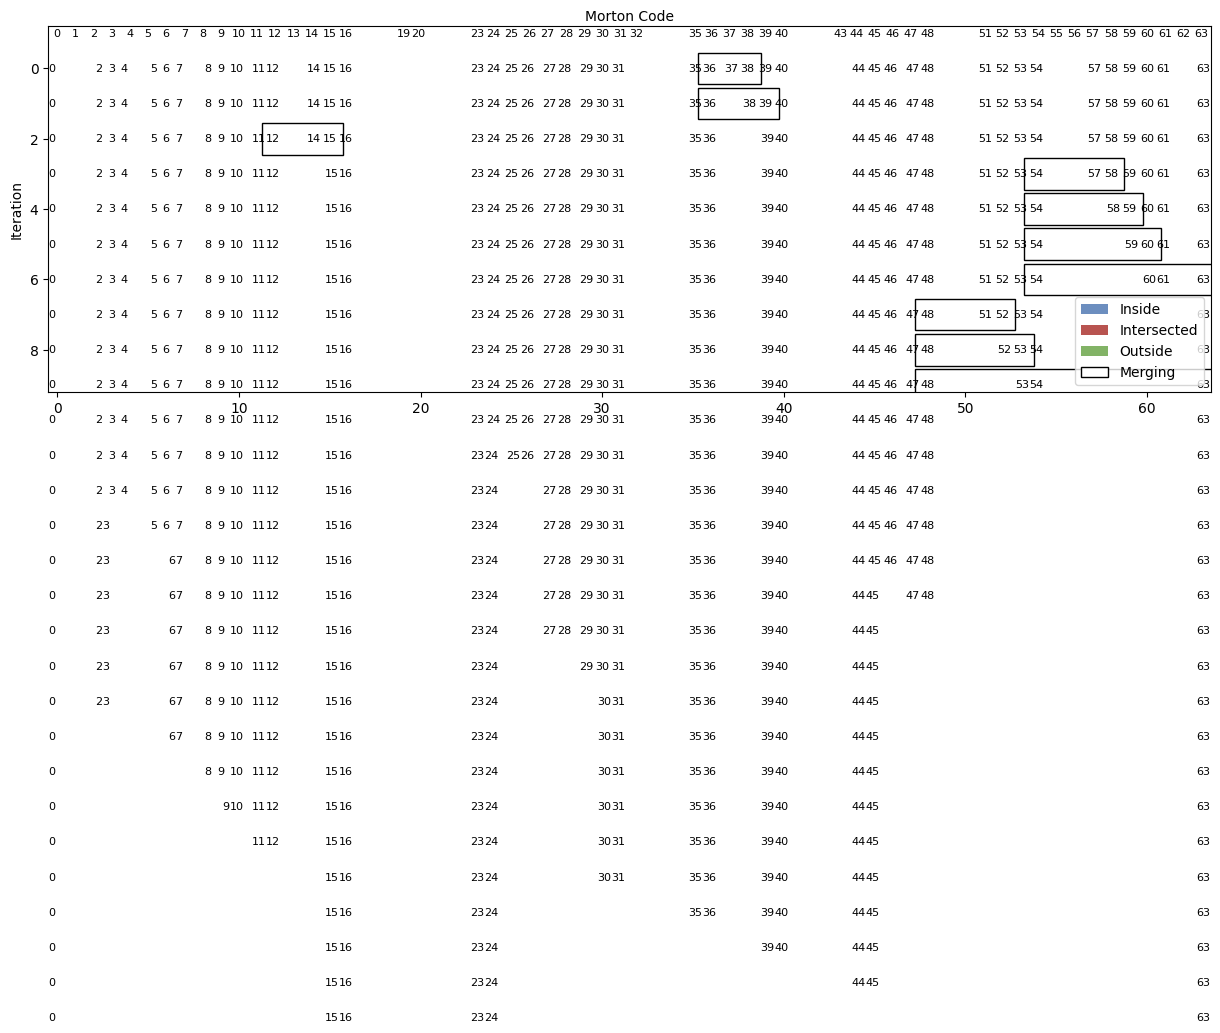

In [170]:
fig, ax = plt.subplots(figsize=(15, 4.75))

for i, ranges in enumerate(results, start=-1):
    outside_size_sum = 0
    intersect_size_sum = 0
    inside_size_sum = 0

    for rng in ranges:
        if rng[2] == -1:
            outside_size_sum += rng[3]
        elif rng[2] == 0:
            intersect_size_sum += rng[3]
        else:
            inside_size_sum += rng[3]

    for left, right, tag, size in ranges:
        pos_left = left - 0.5
        pos_right = right + 0.5
        color = color_map[tag]  # Use the color map
        if tag == -1:
            ax.plot([pos_left, pos_right], [i, i], color=color, lw=10, solid_capstyle='butt', alpha=size / outside_size_sum * 3.0)
        elif tag == 0:
            ax.plot([pos_left, pos_right], [i, i], color=color, lw=10, solid_capstyle='butt', alpha=size / intersect_size_sum * 1.5)
        else:
            ax.plot([pos_left, pos_right], [i, i], color=color, lw=10, solid_capstyle='butt', alpha=size / inside_size_sum)
        if left == right:
            ax.text(left, i, str(left), ha='center', va='center', fontsize=8)
        else:
            ax.text(pos_left, i, str(left), ha='left', va='center', fontsize=8)
            ax.text(pos_right, i, str(right), ha='right', va='center', fontsize=8)

for i, circle in enumerate(circles, start=-1):
    if circle:
        x = circle[0] - 0.75
        y = i - 0.45
        width = circle[1] - circle[0] + 1.5
        height = 0.9
        rect = Rectangle((x, y), width=width, height=height, edgecolor="black", facecolor='none', zorder=4)
        ax.add_patch(rect)

# Define legend elements using the color map
legend_elements = [
    Patch(facecolor=color_map[1], label='Inside'),
    Patch(facecolor=color_map[0], label='Intersected'),
    Patch(facecolor=color_map[-1], label='Outside'),
    Patch(facecolor='white', edgecolor='black', label='Merging'),
]

# Set up the legend and plot details
ax.legend(handles=legend_elements)
ax.set_xlim(-0.5, 63.5)
ax.set_ylim(-1.2, 9.2)
ax.invert_yaxis()
ax.xaxis.set_label_position('top')
ax.set_xlabel('Morton Code')
ax.set_ylabel('Iteration')
# Save and display the figure
plt.show()
fig.savefig("figs/merging.pdf", bbox_inches='tight')

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[16, 17, 18, 19, 20, 21, 22, 23]
[24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]


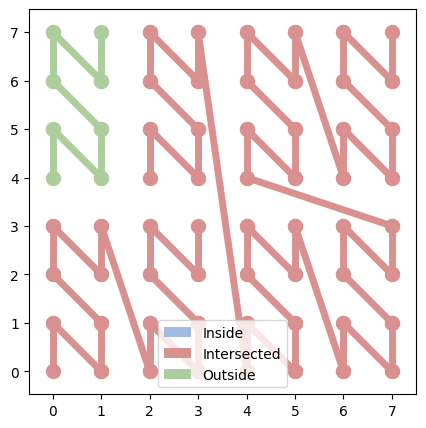

In [171]:
color_map = {-1: '#82B366', 0: '#B85450', 1: '#6C8EBF'}
color_map = {-1: '#D5E8D4', 0: '#F8CECC', 1: '#DAE8FC'}
color_map = {-1: '#ACCE9D', 0: '#D8918E', 1: '#A3BBDE'}
fig, ax = plt.subplots(figsize=(5, 5))

for line in results[-1]:
    color = color_map[line[2]]
    mortons = list(range(line[0], line[1] + 1))
    print(mortons)
    points = [decode_morton_2d(morton, depth_tree) for morton in mortons]
    if len(points) == 1:
        ax.scatter(points[0][0], points[0][1], color=color, marker='o', s=100)
    else:
        for i in range(len(points) - 1):
            start, end = np.array(points[i]), np.array(points[i + 1])
            ax.plot([start[0], end[0]], [start[1], end[1]], color=color, marker="o", linewidth=5, markersize=10)

legend_elements = [
    Patch(facecolor=color_map[1], label='Inside'),
    Patch(facecolor=color_map[0], label='Intersected'),
    Patch(facecolor=color_map[-1], label='Outside'),
]
ax.legend(handles=legend_elements)
ax.axis('equal')
ax.set_xlim(-0.5, 7.5)
ax.set_ylim(-0.5, 7.5)
plt.show()
ax.grid(True)

# Save and display the figure
plt.show()
fig.savefig("figs/merging_{}.pdf".format(iterations), bbox_inches='tight')

In [172]:
from json import load


def loc(nb):
    with open(nb, encoding='utf-8') as data_file:
        cells = load(data_file)['cells']
        return sum(len(c['source']) for c in cells if c['cell_type'] == 'code')


files = ["Core.ipynb", "e1-example.ipynb", "e2-cover.ipynb", "m1-extract.ipynb", "m2-transform.ipynb", "m3-load.ipynb", "m4-analysis.ipynb", "m5-function.ipynb", "t1-compression.ipynb", "t2-distribution.ipynb", "t3-selection.ipynb", "t4-speedup.ipynb", "t5-scaleup.ipynb", "t6-localization.ipynb"]

sum_line = 0

for file in files:
    num_line = loc(file)
    print("num_line:", num_line, "\t", file)
    sum_line = sum_line + num_line
print("sum_line:", sum_line)

num_line: 555 	 Core.ipynb
num_line: 763 	 e1-example.ipynb
num_line: 82 	 e2-cover.ipynb
num_line: 152 	 m1-extract.ipynb
num_line: 117 	 m2-transform.ipynb
num_line: 76 	 m3-load.ipynb
num_line: 53 	 m4-analysis.ipynb
num_line: 40 	 m5-function.ipynb
num_line: 124 	 t1-compression.ipynb
num_line: 119 	 t2-distribution.ipynb
num_line: 203 	 t3-selection.ipynb
num_line: 288 	 t4-speedup.ipynb
num_line: 179 	 t5-scaleup.ipynb
num_line: 219 	 t6-localization.ipynb
sum_line: 2970
